## <img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Classification Tutorial SWDB 2022 </h1> 
<h3 align="center">August XX, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
This tutorial covers some general concepts in classification and highlights useful functionality in the sklearn package for performing classification.
    </p>
    <p>
<b>Classification</b> is closely related to regression. In the case of regression, we're trying to discover a mapping from independent continuous variables onto dependent continuous variables. In the case of classification, we're trying to discover a mapping from independent continous variables onto dependent categorical (i.e. discrete) variables. 
    </p>
    <p>
<i>Whereas regression attempts to find the best fit to the data, classification emphasizes finding the best boundaries to separate classes.</i>
    </p>
    <p>
One prominent use case in systems neuroscience is that <i>decoding is typically framed as a classification problem</i>. For example, mapping an activity vector (cell activity x number of neurons) onto some categorical feature that we believe is represented in that population activity. The category could be which stimulus out of a set of stimuli was presented on that trial, or the behavioral state of the animal (e.g. asleep versus awake, running versus stationary, engaged versus disengaged).
    </p>

In this tutorial you will learn:
- How to use sklearn for linear classification
- How to cross-validate your classifier
- How to use non-linear classifiers, in this case K nearest neighbors
- How to use these classifiers to decode stimulus identify in visual cortex.
            



In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import neighbors

%matplotlib inline

`sklearn.datasets` provides the ability to generate synthetic data that have specific kinds of structure that are useful for understanding and validating the performance of various classification algorithms.

Here, we'll generate a 2D dataset with partial overlap.

In [2]:
X, y = datasets.make_classification(n_features=2,n_redundant=0,random_state=1,n_samples=1000)
        
print(np.shape(X))
print(np.shape(y))

(1000, 2)
(1000,)


Note that the shape of the training sets is X: (num_samples, num_dimensions) and y: (num_samples)

This function can visualize the datasets we'll generate in this tutorial.

In [3]:
def plot_classes(X,y):
    
    classes = np.unique(y)
    num_classes = len(classes)
    
    color = 'rbgmyk'
    
    plt.figure(figsize=(8,8))
    for cl in range(num_classes):
        plt.scatter(X[y==cl,0],X[y==cl,1],c=color[cl],edgecolor='none')
    plt.xlim(X[:,0].min(),X[:,0].max())
    plt.ylim(X[:,1].min(),X[:,1].max())
    plt.show()

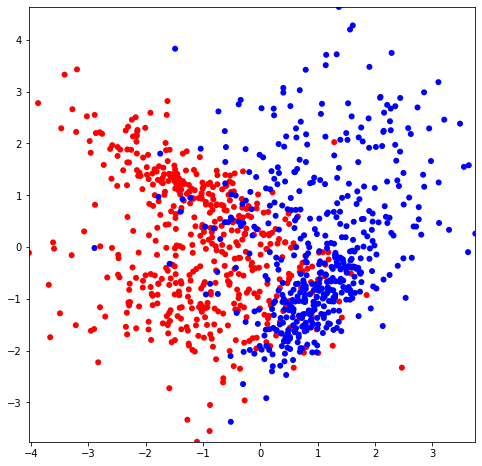

In [4]:
plot_classes(X,y)

It's important to split our data into a *train* and *test* set to ensure that our classifier can generalize to data that it hasn't yet seen. Again sklearn provides a straightforward function to make this split. Here, I'm telling the function that I want 20% of the data held-out for testing.

In [5]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

print(np.shape(X_train))
print(np.shape(y_train))

(800, 2)
(800,)


#### Linear Discriminant Analysis

The first classification algorithm we'll try, and one typically worth trying first, is linear discriminant analysis. LDA will attempt to find a linear boundary between our classes.

[Linear Discriminant Analysis](https://towardsdatascience.com/linear-discriminant-analysis-explained-f88be6c1e00b)

In [6]:
classifier = LDA()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

This function can visualize the test data that is correctly versus incorrectly classified.
Correctly classified data are displayed as filled circles, whereas incorrectly classified data are displayed as open circles.

In [7]:
def plot_test_performance(X,y,y_hat):
    
    classes = np.unique(y_test)
    num_classes = len(classes)
    
    color = 'rbgmyk'
    
    plt.figure(figsize=(8,8))
    for cl in range(num_classes):
        
        is_class = y == cl
        is_correct = y == y_hat
        
        plt.scatter(X[is_class & is_correct,0],X[is_class & is_correct,1],c=color[cl],edgecolor='none')
        plt.scatter(X[is_class & ~is_correct,0],X[is_class & ~is_correct,1],c='none',edgecolor=color[cl])
        
    plt.xlim(X[:,0].min(),X[:,0].max())
    plt.ylim(X[:,1].min(),X[:,1].max())
    plt.show()

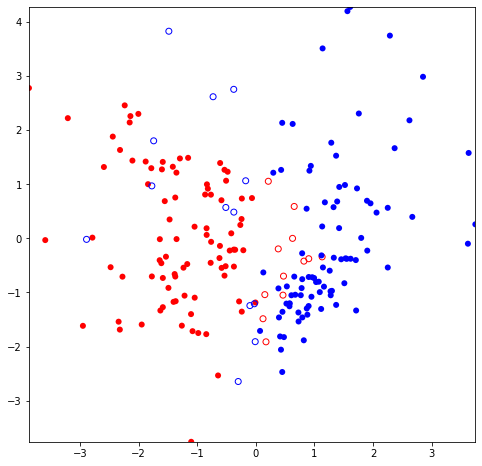

In [8]:
plot_test_performance(X_test,y_test,y_hat)

In order to visualize the actual decision boundary that was learned, this function will push many points on a grid through the classifier and display them.

In [9]:
def plot_classifier_boundary(classifier,X,num_classes=2):

    (grid_x1, grid_x2) = np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),80),np.linspace(X[:,1].min(),X[:,1].max(),80))
    grid = np.vstack([grid_x1.reshape(-1),grid_x2.reshape(-1)]).T
    grid_classes = classifier.predict(grid)   
    
    plot_classes(grid,grid_classes)

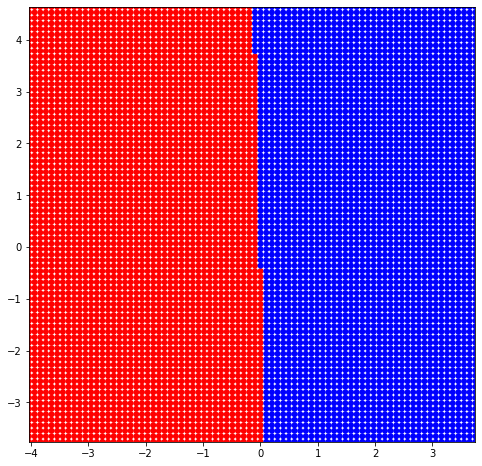

In [10]:
plot_classifier_boundary(classifier,X)

The classifier essentially learns to classify the data based on whether the first dimension is greater than or less than zero.

The next exercise illustrates an important aspect of training classifiers: since the classifier learns both the generalizable structure of the data that we're trying to capture as well as the specific variation (noise) in the training data, **the performance of a classifier can be no better on the test data than on the training data**. Typically, it's worse. This phenomenon is called **overfitting**.

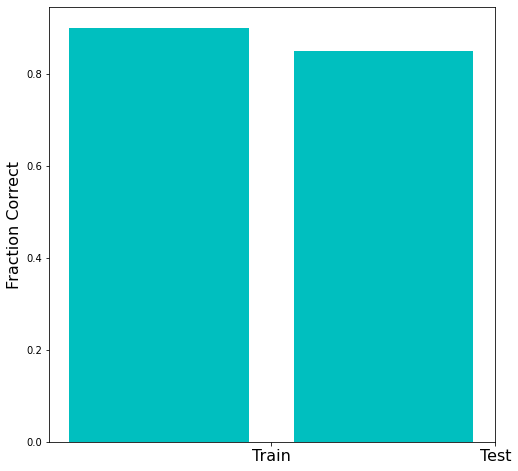

In [11]:
train_accuracy = []
test_accuracy = []
num_folds = 5

X, y = datasets.make_classification(n_features=2,n_redundant=0,random_state=0,n_samples=20)

scores = model_selection.cross_validate(classifier,X,y, cv=5, return_train_score=True)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.bar([0,1],[np.mean(scores['train_score']),np.mean(scores['test_score'])],color='c')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Train','Test'],fontsize=16)
ax.set_ylabel('Fraction Correct',fontsize=16)
plt.show()

Try playing with the number of samples in the dataset above. You'll notice that the gap between the performance on train and test sets gets smaller as the dataset gets larger. That happens because the sample dataset begins to look more like the full population, so large train and test set should have very similar distributions. In other words, as the training set becomes infinitely large, it becomes impossible that the test set encounters a part of the distribution that is not represented in the train set.

Next, let's try a dataset that isn't so easily separated by a linear classifier.

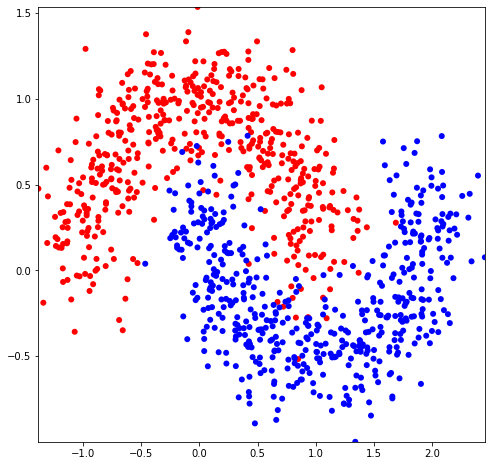

In [12]:
X, y = datasets.make_moons(noise=0.2,random_state=0,n_samples=1000)
    
plot_classes(X,y)

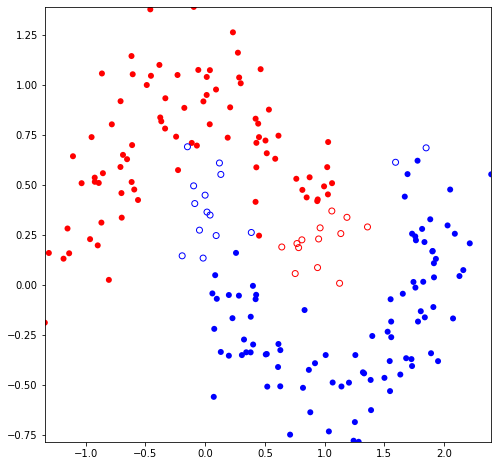

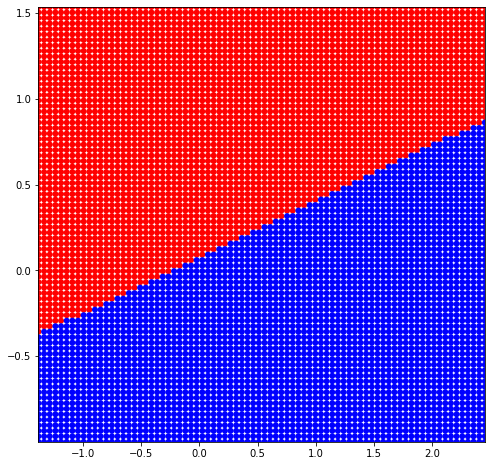

In [13]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

classifier = LDA()
classifier.fit(X_train,y_train)
y_hat_lda = classifier.predict(X_test)

plot_test_performance(X_test,y_test,y_hat_lda)
plot_classifier_boundary(classifier,X)

#### K-nearest neighbors

Let's try a non-linear classifier. K-nearest neighbors is a very straightforward non-linear classifier that just uses the class mode of the closest data points in the training set.

[K-nearest neighbors](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)

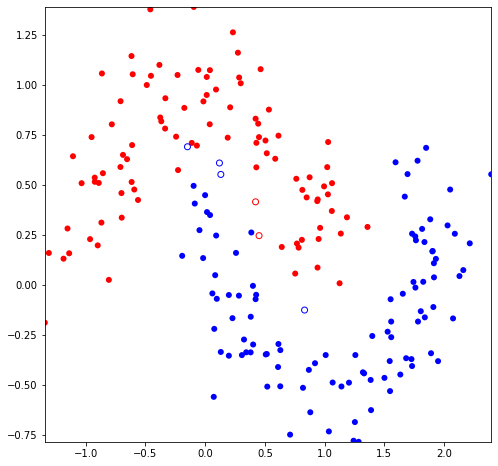

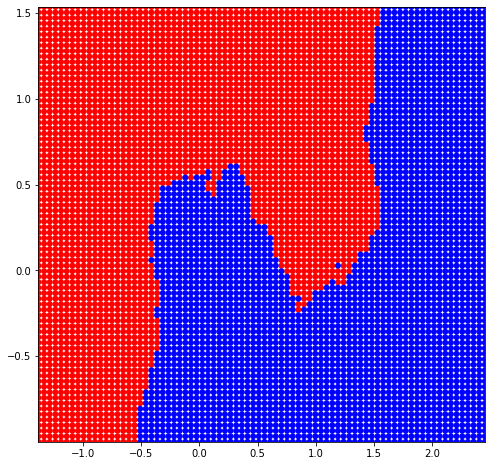

In [14]:
classifier = neighbors.KNeighborsClassifier()
classifier.fit(X_train,y_train)

y_hat_knn = classifier.predict(X_test)

plot_test_performance(X_test,y_test,y_hat_knn)
plot_classifier_boundary(classifier,X)

The performance of the KNN classifier depends on the number of neighbors that are considered for deciding class membership. We can determine the best value of K through **validation**.

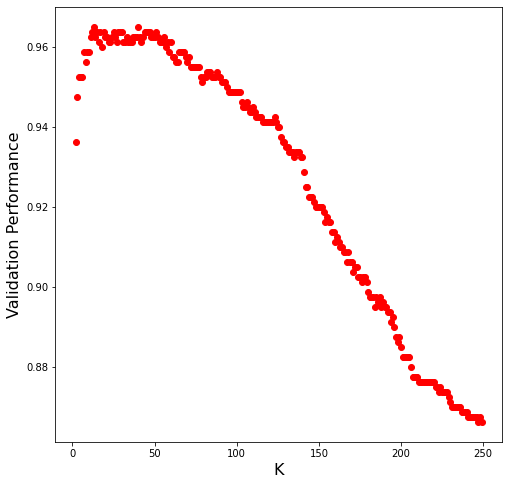

In [15]:
k_to_try = np.arange(2,250,1)
val_performance = np.zeros(np.shape(k_to_try))
for ki, k in enumerate(k_to_try):
    
    classifier = neighbors.KNeighborsClassifier(n_neighbors=k)

    scores = model_selection.cross_validate(classifier,X_train,y_train, cv=3)
    
    val_performance[ki] = np.mean(scores['test_score'])

plt.figure(figsize=(8,8))
plt.plot(k_to_try,val_performance,'ro')
plt.xlabel('K',fontsize=16)
plt.ylabel('Validation Performance',fontsize=16)
plt.show()

Now let's use the best value of K from validation to see how well it generalizes to the hold-out test set.

In [16]:
best_K = k_to_try[np.argmax(val_performance)]

classifier = neighbors.KNeighborsClassifier(n_neighbors=best_K)
classifier.fit(X_train,y_train)

y_hat = classifier.predict(X_test)
 
print("Best K: " + str(best_K))
print("Validation Performance: " + str(val_performance.max()))
print("Test Performance: " + str(np.mean(y_test == y_hat)))

Best K: 13
Validation Performance: 0.9650061483296256
Test Performance: 0.975


Let's quantitatively compare the performance of LDA and KNN.

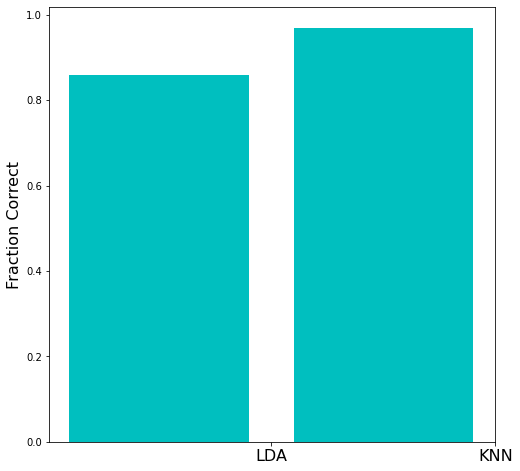

In [17]:
test_accuracy = np.array([
                          (y_test==y_hat_lda).mean(),
                          (y_test==y_hat_knn).mean()
                        ])

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.bar([0,1],test_accuracy,color='c')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['LDA','KNN'],fontsize=16)
ax.set_ylabel('Fraction Correct',fontsize=16)
plt.show()

There are many more types of datasets you can make with scikit-learn, many of which are not linearly classifiable.

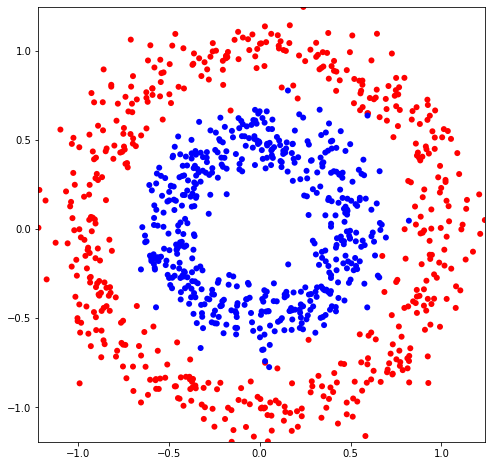

In [18]:
X, y = datasets.make_circles(noise=0.1, factor=0.5, random_state=1,n_samples=1000)
    
plot_classes(X,y)

Now let's look at a dataset with more than two classes.

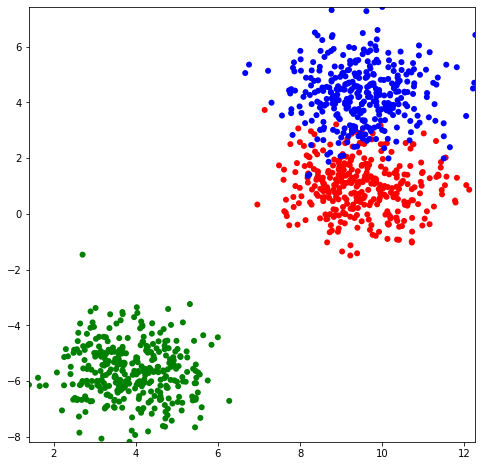

In [19]:
X, y = datasets.make_blobs(n_features=2, centers=3,random_state=4,n_samples=1000)
       
plot_classes(X,y)

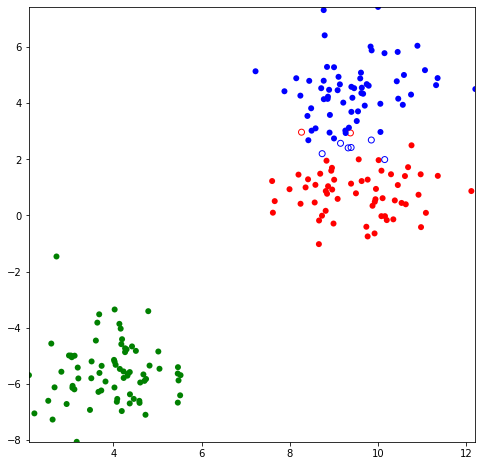

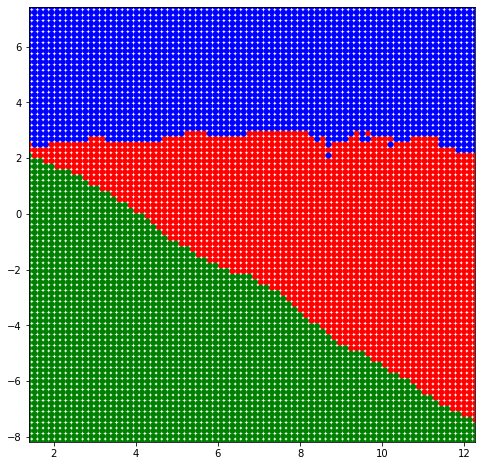

In [20]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

classifier = neighbors.KNeighborsClassifier()
classifier.fit(X_train,y_train) 
y_hat = classifier.predict(X_test)

plot_test_performance(X_test,y_test,y_hat) 
plot_classifier_boundary(classifier,X)

Note that the red and blue classes overlap, but neither overlaps with the green class. One method commonly used to determine which classes are more difficult for a classifier to distinguish is to make a "confusion matrix." This is simply a matrix comparing the actual class a datapoint belongs to the class that is predicted by the classifier.

#### Confusion Matrix

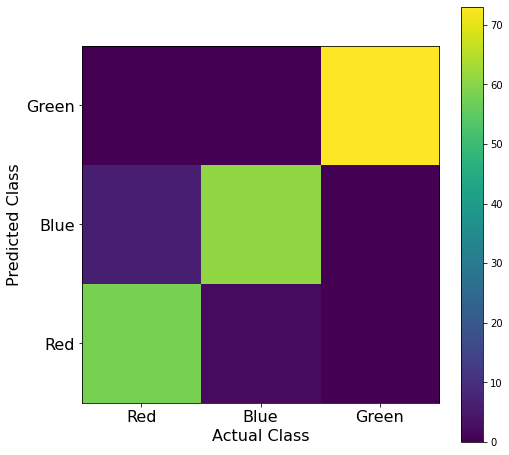

In [21]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(y_test,y_hat)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
ax.set_xticks(range(3))
ax.set_xticklabels(['Red','Blue','Green'],fontsize=16)
ax.set_yticks(range(3))
ax.set_yticklabels(['Red','Blue','Green'],fontsize=16)
plt.colorbar(cax)

Side note: Classification is related to another technique called clustering. Classification is performed when you have class labels, whereas clustering is performed when you do not. The former is known as supervised learning and the latter is known as unsupervised learning.

sklearn, as you might have guess, has a number of built in clustering algorithms. As with classification, different algorithms make different underlying assumptions about the data at hand. You can read about these here: https://scikit-learn.org/stable/modules/clustering.html

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

### Once again, lets try to decoding in the Visual Behavior dataset.
    
<p>
    Specifically, we will try and decode which image was presented to a mouse during a string of behavior trials
    </p>

In [22]:
# Set upt data cache
import allensdk
from allensdk.brain_observatory.\
    behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
# For now, just use this:
cache_dir = "../../Data"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=cache_dir)

In [23]:
# We are going to find the "familiar" session that contains the most V1 units. 
area = 'VISp'
# You have actually seen this code before, so we won't spend time on it...
units_table = cache.get_unit_table()
ecephys_sessions_table = cache.get_ecephys_session_table()

# For now, we are going to grab the one with the most V! units.
unit_by_session = units_table.join(ecephys_sessions_table,on = 'ecephys_session_id')
unit_in = unit_by_session[(unit_by_session['structure_acronym']==area) &\
                          (unit_by_session['experience_level']=='Familiar') &\
                          (unit_by_session['isi_violations']<.5)&\
                          (unit_by_session['amplitude_cutoff']<0.1)&\
                          (unit_by_session['presence_ratio']>0.95)]
unit_count = unit_in.groupby(["ecephys_session_id"]).count()
familiar_session_with_most_in_units = unit_count.index[np.argmax(unit_count['ecephys_probe_id'])]
# Actually imort the data
session = cache.get_ecephys_session(ecephys_session_id=familiar_session_with_most_in_units)



C:\Users\yoni.browning\Anaconda3\envs\swdb_allensdk\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [24]:
# Get unit information
session_units = session.get_units()
# Channel information
session_channels = session.get_channels()
# And accosiate each unit with the channel on which it was found with the largest amplitude
units_by_channels= session_units.join(session_channels,on = 'peak_channel_id')

# Filter for units in primary visual cortex
this_units = units_by_channels[(units_by_channels.structure_acronym == area)\
                               &(units_by_channels['isi_violations']<.5)\
                               &(units_by_channels['amplitude_cutoff']<0.1)\
                               &(units_by_channels['presence_ratio']>0.95)]
# Get the spiketimes from these units as a dictionary
this_spiketimes = dict(zip(this_units.index, [session.spike_times[ii] for ii in this_units.index]))

In [25]:
# Next, get the stimulus table for the behavior session:
active_stims = session.stimulus_presentations[session.stimulus_presentations.stimulus_block==0 ]

Just as with PCA, we need to construct a matrix X (𝑇,𝑛) row per time sample and one column per neuron/dimension.

Once again, the time scale that we choose will have a major impact on what we can learn from our classifier. In this case, we are going consider each timepoint as a trial, looking at the number of spikes from each neuron in the 250 ms after an image is show.


In [26]:
# We first need a function that counts the number of times a neuron spikes within a given time window
def count_spikes_after_event(spiketimes,eventtime,window):
    tmp = spiketimes-eventtime 
    count = np.count_nonzero(np.bitwise_and(tmp>=0,tmp<window))
    return count

In [27]:
# Declare and empty variable X
X = np.zeros((len(active_stims),len(this_spiketimes)))
# This Loop is a little slow...be patient
# Loop Through both trials and units, counting the number of spikes
for jj,key in enumerate(this_spiketimes):
    # Loop through the trials
    for ii, trial in active_stims.iterrows():
        # Count the number of spikes per trial. 
        X[ii,jj] = count_spikes_after_event(this_spiketimes[key],trial.start_time,.25)

The "unique" command in numpy has a handy feature that converts non-numeric catigories to numeric ones. 

"Unique" returns a list of each unique value in a list. The inverse of the unique function provides the index needed to ruturn that list back to its origional state. Convienetly, for a discrete variable, this means that the inverse returned by the unique function provides a integer catigory marker for non-integer data



In [28]:
[unq,cat]= np.unique(active_stims.image_name,return_inverse=True)
cat

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

We should take a moment to note that dimensionality reduction techniques, like PCA, are often useful in assessing how successful a decoding algorithm might be. If you can easily visuallize stratification in your data, it will likely be easy for a classifier to determine boundries between groups in your data. Lets take a moment to look at the first two PCs of our response matrix, X. Do you think we are going to have much luck with our classifier?

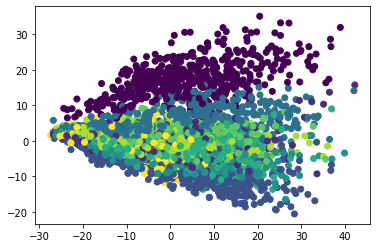

In [29]:
from sklearn.decomposition import PCA
pca = PCA()
trans = pca.fit_transform(X)
plt.scatter(trans[:,0],trans[:,1],c = cat)

Looks like this is likely going to work!

Exersize (1): Choose a sklearn classifier! LDA and KNN are clearly some favorites, but if you are feeling fancy you are welcome to look at others here: https://scikit-learn.org/stable/supervised_learning.html

You have a matrix "X: and classes "cat". Seperate these into training and testing data, then fit and evaluate your classifier. What is your error rate?

In [30]:
# Solution
[X_train,X_test,cat_train,cat_test] = model_selection.train_test_split(X,cat,test_size=0.2,stratify=cat)
classifier = LDA()
classifier.fit(X_train,cat_train)
cat_hat = classifier.predict(X_test) #NOW you know why this variable was called "cat"


Exersize (2): Construct a confusion and plot a confusion matrix for your classifier.

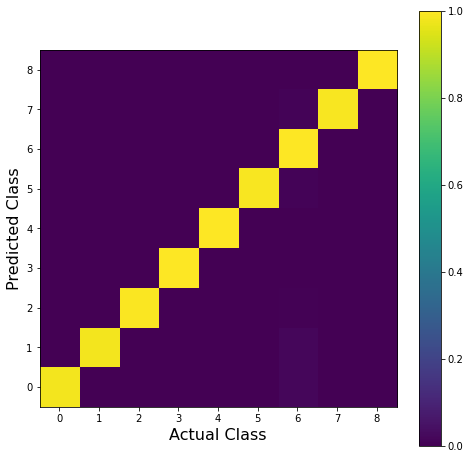

In [31]:
# Solution
C = confusion_matrix(cat_test,cat_hat,normalize='true')           
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
plt.colorbar(cax)

Exersize (3): V1 was a (maybe too) easy example for this problem. Try playing around with different brain areas to if they do as well (hint: change the "area" variable).

Finally (if there is time), its worth noting at some classifiers can measure how important an particular feature was in making their classification. 

One example of this is a decision tree. Decision trees are useful because the results are easily interpretable - in the end, you get a series of choices on the values of individual features that tell you which class to assign any given datapoint to. They're called decision trees because you always start at the same point ("the root") and each consecutive choice leads you down a particular branch, until you arrive at a class assignment ("the leaves").

A Decision tree object also returns a "feature_imortances_" variable. Feature importance (see "Gini Importance") gives a sense of how heavily each feature is weighted in the decision tree. In this case, It tells us how important each cell is in the classifier's decision process.

Text(0, 0.5, 'Importance Score')

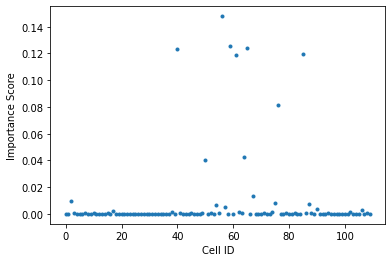

In [32]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=0)
classifier = classifier.fit(X_train, cat_train)

plt.plot(classifier.feature_importances_,'.')
plt.xlabel("Cell ID")
plt.ylabel('Importance Score')